# Hypothesis-driven and discovery-driven analysis with CEBRA

In this notebook, we show how to:

- use CEBRA-Time and CEBRA-Behavior and CEBRA-Hybrid in an hypothesis-driven or discovery-driven analysis.

- use CEBRA-Behavior more specifically in an hypothesis-driven analysis, by testing different hypothesis on positon and direction encoding. 

It is mostly based on what we present in [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

**Install note**
- Be sure you have cebra, and the demo dependencies, installed to use this notebook: 

In [ ]:
!pip install --pre 'cebra[datasets,demos]'

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

## Load the data

- The data will be automatically downloaded into a `/data` folder.

In [2]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

100%|██████████| 10.0M/10.0M [00:01<00:00, 8.25MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


## CEBRA workflow: Discovery-driven and Hypothesis-driven analysis.

- We will compare CEBRA-Time (discovery-driven), CEBRA-Behavior and CEBRA-Hybrid models (hypothesis-driven) as in the recommended [CEBRA workflow](https://cebra.ai/docs/usage.html#the-cebra-workflow).

- We use an output dimension set to 3; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

**------------------- BEGINNING OF TRAINING SECTION -------------------**

### Train the models

*[You can skip this section if you already have the models saved]*

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [3]:
max_iterations = 10000 #default is 5000.

#### CEBRA-Time: Train a model that uses time without the behavior information. 
- We can use CEBRA -Time mode by setting conditional = 'time'

In [7]:
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

We train the model with neural data only.

In [8]:
cebra_time_model.fit(hippocampus_pos.neural)
cebra_time_model.save("cebra_time_model.pt")

pos:  0.0254 neg:  5.4793 total:  5.5047 temperature:  1.1200: 100%|█| 10000/10000 [03:06<00:00, 53.59it/s


#### CEBRA-Behavior: Train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [9]:
cebra_behavior_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

We train the model with neural data and the behavior variable including position and direction. 

In [10]:
cebra_behavior_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_behavior_model.save("cebra_behavior_model.pt")

pos:  0.1052 neg:  5.4142 total:  5.5195 temperature:  1.0000: 100%|█| 10000/10000 [03:08<00:00, 52.98it/s


#### CEBRA-Hybrid: Train a model that uses both time and positional information. 

In [11]:
cebra_hybrid_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10,
                        hybrid = True)

In [12]:
cebra_hybrid_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_hybrid_model.save("cebra_hybrid_model.pt")

behavior_pos:  0.1015 behavior_neg:  5.4163 behavior_total:  5.5179 time_pos:  0.0773 time_neg:  5.4163 ti


#### CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

In [13]:
cebra_behavior_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

- Now we train the model with shuffled behavior variable. 

In [14]:
# Shuffle the behavior variable and use it for training
hippocampus_shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())

cebra_behavior_shuffled_model.fit(hippocampus_pos.neural, hippocampus_shuffled_posdir)
cebra_behavior_shuffled_model.save("cebra_behavior_shuffled_model.pt")

pos:  0.3397 neg:  5.8153 total:  6.1549 temperature:  1.0000: 100%|█| 10000/10000 [03:08<00:00, 52.93it/s


**------------------- END OF TRAINING SECTION -------------------**

### Load the models and get the corresponding embeddings

In [4]:
# CEBRA-Time
cebra_time_model = cebra.CEBRA.load("cebra_time_model.pt")
cebra_time = cebra_time_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior
cebra_behavior_model = cebra.CEBRA.load("cebra_behavior_model.pt")
cebra_behavior = cebra_behavior_model.transform(hippocampus_pos.neural)

# CEBRA-Hybrid
cebra_hybrid_model = cebra.CEBRA.load("cebra_hybrid_model.pt")
cebra_hybrid = cebra_hybrid_model.transform(hippocampus_pos.neural)

# CEBRA-Behavior with shuffled labels
cebra_behavior_shuffled_model = cebra.CEBRA.load("cebra_behavior_shuffled_model.pt")
cebra_behavior_shuffled = cebra_behavior_shuffled_model.transform(hippocampus_pos.neural)

### Visualize the embeddings from CEBRA-Behavior, CEBRA-Time and CEBRA-Hybrid

In [5]:
right = hippocampus_pos.continuous_index[:,1] == 1
left = hippocampus_pos.continuous_index[:,2] == 1

**Note to Google Colaboratory users:** replace the first line of the next cell (``%matplotlib notebook``) with ``%matplotlib inline``.

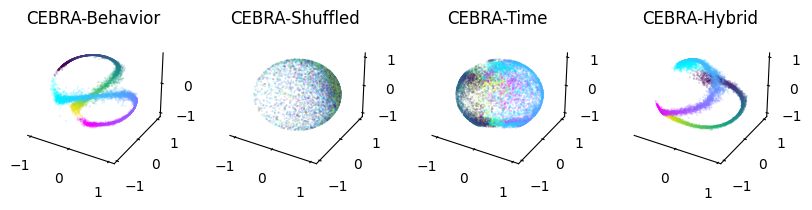

In [6]:
%matplotlib notebook

fig = plt.figure(figsize=(10,2))

ax1 = plt.subplot(141, projection='3d')
ax2 = plt.subplot(142, projection='3d')
ax3 = plt.subplot(143, projection='3d')
ax4 = plt.subplot(144, projection='3d')

for dir, cmap in zip([right, left], ["cool", "viridis"]):
    ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_behavior[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Behavior', cmap=cmap)
    ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_behavior_shuffled[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Shuffled', cmap=cmap)
    ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_time[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Time', cmap=cmap)
    ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_hybrid[dir,:], embedding_labels=hippocampus_pos.continuous_index[dir,0], title='CEBRA-Hybrid', cmap=cmap)

plt.show()

## Hypothesis testing: compare models with different hypothesis on position encoding of hippocampus

- We will compare CEBRA-Behavior models trained with only position, only direction, both and the control models with shuffled behavior variables. 

- Here, we use the set model dimension; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

In [7]:
def split_data(data, test_ratio):

    split_idx = int(len(data)* (1-test_ratio))
    neural_train = data.neural[:split_idx]
    neural_test = data.neural[split_idx:]
    label_train = data.continuous_index[:split_idx]
    label_test = data.continuous_index[split_idx:]
    
    return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

neural_train, neural_test, label_train, label_test = split_data(hippocampus_pos, 0.2)

**------------------- BEGINNING OF TRAINING SECTION -------------------**

### Train the models

*[This can be skipped if you already saved the models].*

#### Train CEBRA-Behavior with position, direction variables and both.

In [8]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [9]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir_model.save("cebra_posdir_model.pt")

# Train CEBRA-Behavior models with position only.
cebra_pos_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

# Train CEBRA-Behavior models with direction only.
cebra_dir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos:  0.1107 neg:  5.3911 total:  5.5018 temperature:  1.0000: 100%|█| 10000/10000 [03:09<00:00, 52.64it/s
pos:  0.1264 neg:  5.4856 total:  5.6120 temperature:  1.0000: 100%|█| 10000/10000 [03:08<00:00, 52.93it/s
pos:  0.0532 neg:  5.5910 total:  5.6442 temperature:  1.0000: 100%|█| 10000/10000 [03:08<00:00, 53.18it/s


#### Train control models with shuffled behavior variables. 

In [10]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

In [11]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())
shuffled_pos = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,0])
shuffled_dir = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,1])


# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(hippocampus_pos.neural, shuffled_posdir)
cebra_posdir_shuffled_model.save("cebra_posdir_shuffled_model.pt")

cebra_pos_shuffled_model.fit(hippocampus_pos.neural, shuffled_pos)
cebra_pos_shuffled_model.save("cebra_pos_shuffled_model.pt")

cebra_dir_shuffled_model.fit(hippocampus_pos.neural, shuffled_dir)
cebra_dir_shuffled_model.save("cebra_dir_shuffled_model.pt")

pos:  0.2714 neg:  5.8641 total:  6.1355 temperature:  1.0000: 100%|█| 10000/10000 [03:09<00:00, 52.67it/s
pos:  0.2765 neg:  5.8482 total:  6.1248 temperature:  1.0000: 100%|█| 10000/10000 [03:08<00:00, 53.05it/s
pos:  0.1813 neg:  5.8203 total:  6.0016 temperature:  1.0000: 100%|█| 10000/10000 [03:07<00:00, 53.42it/s


**------------------- END OF TRAINING SECTION -------------------**

### Load the model and get the corresponding embeddings

In [12]:
# We get train set embedding and test set embedding. 

cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir = cebra_posdir_model.transform(hippocampus_pos.neural)

cebra_pos_model = cebra.CEBRA.load("cebra_pos_model.pt")
cebra_pos = cebra_pos_model.transform(hippocampus_pos.neural)

cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir = cebra_dir_model.transform(hippocampus_pos.neural)

In [13]:
# ... and similarily for models with shuffled variables

cebra_posdir_shuffled_model = cebra.CEBRA.load("cebra_posdir_shuffled_model.pt")
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)

cebra_pos_shuffled_model = cebra.CEBRA.load("cebra_pos_shuffled_model.pt")
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)

cebra_dir_shuffled_model = cebra.CEBRA.load("cebra_dir_shuffled_model.pt")
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)

### Visualize embeddings from different hypothesis

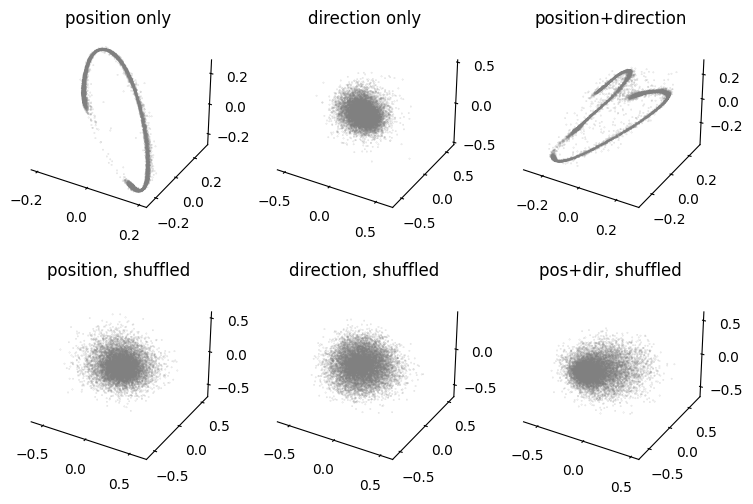

In [15]:
fig=plt.figure(figsize=(9,6))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_pos, embedding_labels="grey", title='position only')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_dir, embedding_labels="grey", title='direction only')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_posdir, embedding_labels="grey", title='position+direction')
ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_pos_shuffled_train, embedding_labels="grey", title='position, shuffled')
ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_dir_shuffled_train, embedding_labels="grey", title='direction, shuffled')
ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_posdir_shuffled_train, embedding_labels="grey", title='pos+dir, shuffled')
    
plt.show()

### Visualize the loss of models trained with different hypothesis

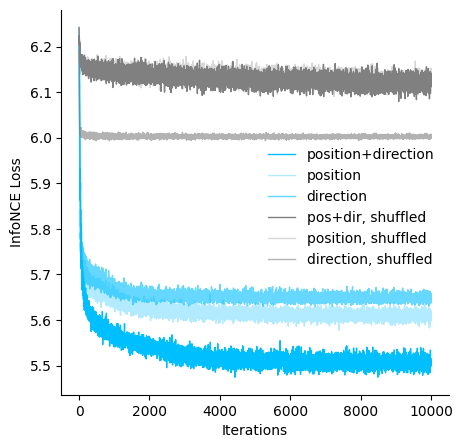

In [17]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_posdir_model, color='deepskyblue', label='position+direction', ax=ax)
ax = cebra.plot_loss(cebra_pos_model, color='deepskyblue', alpha=0.3, label='position', ax=ax)
ax = cebra.plot_loss(cebra_dir_model, color='deepskyblue', alpha=0.6,label='direction', ax=ax)

ax = cebra.plot_loss(cebra_posdir_shuffled_model, color='gray', label='pos+dir, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_pos_shuffled_model, color='gray', alpha=0.3, label='position, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_dir_shuffled_model, color='gray', alpha=0.6, label='direction, shuffled', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.show()